In [1]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif


from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

import shap
import warnings
warnings.filterwarnings("ignore")

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
zip_path = "C:/Users/user/Downloads/diabetes+130-us+hospitals+for+years+1999-2008.zip"
print(zip_path)

C:/Users/user/Downloads/diabetes+130-us+hospitals+for+years+1999-2008.zip


In [3]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    print("Files in ZIP:", zip_ref.namelist())
    
    data = pd.read_csv(zip_ref.open('diabetic_data.csv'))
    print(f"Loaded 'diabetic_data', shape: {data.shape}")

Files in ZIP: ['diabetic_data.csv', 'IDS_mapping.csv']
Loaded 'diabetic_data', shape: (101766, 50)


In [4]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
missing_placeholders = ['?', 'None', 'NA', 'na', 'nan', '']
data.replace(missing_placeholders, np.nan, inplace=True)

categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical columns:", len(categorical_cols))
print("Numerical columns:", len(numerical_cols))

Categorical columns: 37
Numerical columns: 13


In [6]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [7]:
# Replace '?' with NaN for easier handling
data.replace('?', np.nan, inplace=True)

# Drop columns with too many missing values or irrelevant info
data.drop(columns=['weight', 'payer_code', 'medical_specialty', 'encounter_id', 'patient_nbr'], inplace=True, errors='ignore')

# Drop duplicates
data.drop_duplicates(inplace=True)

print("After cleaning:", data.shape)

After cleaning: (101766, 45)


In [8]:
data.head()
data.isnull().sum()

race                         2273
gender                          0
age                             0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone 

In [9]:
# Check which readmission columns exist
readmit_cols = [col for col in data.columns if 'readmit' in col.lower()]
print("Readmission-related columns found:", readmit_cols)

if 'readmitted' in data.columns:
    data['readmitted_target'] = data['readmitted'].apply(lambda x: 1 if x == '>30' else 0)
    data.drop(columns=['readmitted'], inplace=True)
elif 'readmitted_>30' in data.columns:
    data['readmitted_target'] = data['readmitted_>30'].astype(int)
else:
    print("Warning: 'readmitted' column not found!")

print("Target column added:", 'readmitted_target' in data.columns)

Readmission-related columns found: ['readmitted']
Target column added: True


In [10]:
data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted_target
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,...,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,1
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,0


In [11]:
X = data.drop(columns=['readmitted_target'], errors='ignore')
y = data['readmitted_target']

print("Feature shape:", X.shape)
print("Target distribution:\n", y.value_counts())

Feature shape: (101766, 44)
Target distribution:
 readmitted_target
0    66221
1    35545
Name: count, dtype: int64


In [12]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print("Numeric columns:", len(numeric_features))
print("Categorical columns:", len(categorical_features))

Numeric columns: 11
Categorical columns: 33


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_features = ['feature1', 'feature2']  # Replace with your numeric feature names
categorical_features = ['feature3', 'feature4']  # Replace with your categorical feature names

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Using mean instead of median
    ('scaler', StandardScaler(with_mean=False))  # Scaling without subtracting mean
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Using constant imputer
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)



In [14]:
data.head()




,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted_target
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,...,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,1
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,0


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

Training shape: (81412, 44)
Testing shape: (20354, 44)


In [16]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Assuming X and y are your dataset's features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_processed = preprocessor.fit_transform(X_train)
print("Before balancing:", Counter(y_train))

smote = SMOTE(random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X_processed, y_train)
print("After balancing:", Counter(y_resampled))



Before balancing: Counter({0: 52984, 1: 28428})
After balancing: Counter({0: 52984, 1: 52984})


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# Lightweight configs to avoid long runtime
models = {
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=8, random_state=42, n_jobs=-1),
    "SVM": SVC(kernel='rbf', C=1, gamma='scale', random_state=42),
    "XGBoost": XGBClassifier(n_estimators=50, max_depth=6, learning_rate=0.1, n_jobs=-1, random_state=42, verbosity=0)
}

cv_results = {}

for name, model in models.items():
    print(f"Training {name} ...")
    scores = cross_val_score(model, X_resampled, y_resampled, cv=3, scoring='accuracy', n_jobs=-1)
    cv_results[name] = np.mean(scores)
    print(f"{name} - Mean CV Accuracy: {np.mean(scores):.4f}")

Training Random Forest ...
Random Forest - Mean CV Accuracy: 0.6540
Training SVM ...
SVM - Mean CV Accuracy: 0.6469
Training XGBoost ...
XGBoost - Mean CV Accuracy: 0.6847


In [ ]:
# -------------------- Feature selection setup --------------------
from sklearn.feature_selection import SelectKBest, f_classif

# Example: keep top 20 features based on ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=20)

# If you have fewer features or want to keep all, you can also do:
# selector = SelectKBest(score_func=f_classif, k='all')


In [ ]:
# --- Fast Hyperparameter Tuning (RF & XGB) ---

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

RNG = 42

# Simple pipeline (assuming preprocessor & selector exist)
def build_pipeline(clf):
    return Pipeline([('preproc', preprocessor), ('select', selector), ('clf', clf)])

# Smaller parameter grids for speed
rf_params = {
    'clf__n_estimators': randint(50, 150),
    'clf__max_depth': randint(3, 10)
}
xgb_params = {
    'clf__n_estimators': randint(50, 150),
    'clf__max_depth': randint(3, 8),
    'clf__learning_rate': uniform(0.05, 0.2)
}

# Faster CV (3-fold)
cv = StratifiedKFold(3, shuffle=True, random_state=RNG)

# RandomForest quick tuning
rf_search = RandomizedSearchCV(
    build_pipeline(RandomForestClassifier(random_state=RNG, n_jobs=-1)),
    rf_params, n_iter=5, scoring='roc_auc', cv=cv, random_state=RNG, n_jobs=-1, verbose=1
)
rf_search.fit(X_train, y_train)
print("Best RF params:", rf_search.best_params_)

# XGBoost quick tuning
xgb_search = RandomizedSearchCV(
    build_pipeline(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RNG, n_jobs=1)),
    xgb_params, n_iter=5, scoring='roc_auc', cv=cv, random_state=RNG, n_jobs=-1, verbose=1
)
xgb_search.fit(X_train, y_train)
print("Best XGB params:", xgb_search.best_params_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best RF params: {'clf__max_depth': 9, 'clf__n_estimators': 132}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best XGB params: {'clf__learning_rate': np.float64(0.0812037280884873), 'clf__max_depth': 5, 'clf__n_estimators': 136}


In [ ]:
# fast_imputation.py
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

# Make copies
X_train_imp = X_train.copy()
X_test_imp = X_test.copy()

# Separate categorical and numerical columns
cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object" or str(X_train[c].dtype).startswith("category")]
num_cols = [c for c in X_train.columns if c not in cat_cols]

# --- Numerical columns ---
if num_cols:
    num_imp = SimpleImputer(strategy='median')
    X_train_imp[num_cols] = num_imp.fit_transform(X_train[num_cols])
    X_test_imp[num_cols] = num_imp.transform(X_test[num_cols])

# --- Categorical columns ---
if cat_cols:
    cat_imp = SimpleImputer(strategy='most_frequent')
    X_train_imp[cat_cols] = cat_imp.fit_transform(X_train[cat_cols])
    X_test_imp[cat_cols] = cat_imp.transform(X_test[cat_cols])

    # Encode categoricals
    enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    X_train_imp[cat_cols] = enc.fit_transform(X_train_imp[cat_cols])
    X_test_imp[cat_cols] = enc.transform(X_test_imp[cat_cols])

print("✅ Fast imputation complete. Shapes:", X_train_imp.shape, X_test_imp.shape)


✅ Fast imputation complete. Shapes: (81412, 44) (20354, 44)


In [ ]:
# 2_feature_selection.py
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, mutual_info_classif
import numpy as np
import pandas as pd

# Use imputed X (from previous step) if available
X_sel = X_train_imp if 'X_train_imp' in globals() else X_train.copy()
y_sel = y_train.copy()

# 1) Univariate filter: mutual information
mi = mutual_info_classif(X_sel, y_sel, random_state=42)
mi_series = pd.Series(mi, index=X_sel.columns).sort_values(ascending=False)

# Keep top 100 or all if fewer
k = min(100, X_sel.shape[1])
top_univariate = mi_series.head(k).index.tolist()

# 2) Model-based: RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_sel[top_univariate], y_sel)
sfm = SelectFromModel(rf, threshold="median", prefit=True)
mask = sfm.get_support()
selected_features = list(pd.Series(top_univariate)[mask])

# Final feature list
final_features = selected_features if selected_features else top_univariate[:20]
print("Selected features (count):", len(final_features))


Selected features (count): 22


In [ ]:
# 3_time_split.py
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# If data has a date column like 'admit_date' / 'admission_date' / 'encounter_time'
date_cols = [c for c in data.columns if 'date' in c.lower() or 'time' in c.lower()]
if date_cols:
    date_col = date_cols[0]
    print("Using temporal split on:", date_col)
    data_sorted = data.sort_values(by=date_col)
    # hold out last 20% chronologically as test (if you need to re-create splits)
    n = len(data_sorted)
    cutoff = int(n*0.8)
    train_idx = data_sorted.index[:cutoff]
    test_idx = data_sorted.index[cutoff:]
    X_train_time = data.loc[train_idx, final_features]
    y_train_time = data.loc[train_idx, y_train.name] if hasattr(y_train, 'name') else y_train.loc[train_idx]
    X_test_time  = data.loc[test_idx, final_features]
    y_test_time  = data.loc[test_idx, y_test.name] if hasattr(y_test, 'name') else y_test.loc[test_idx]
else:
    print("No date column found — using stratified split for temporality fallback.")
    X_time = X_train_imp[final_features] if 'X_train_imp' in globals() else X_train[final_features]
    X_train_time, X_test_time, y_train_time, y_test_time = train_test_split(
        X_time, y_train, test_size=0.2, stratify=y_train, random_state=42)

print("Temporal split shapes:", X_train_time.shape, X_test_time.shape)


Using temporal split on: time_in_hospital
Temporal split shapes: (81412, 22) (20354, 22)



🚀 Training RF...
✅ RF -> F1: 0.0000, ROC AUC: 0.6421, Time: 6.94s

🚀 Training XGB...
✅ XGB -> F1: 0.2995, ROC AUC: 0.6635, Time: 2.86s

🚀 Training LinearSVM...
✅ LinearSVM -> F1: 0.2310, ROC AUC: 0.6200, Time: 18.42s


,Model,F1 Score,Brier Score,ROC AUC,Train Time (s)
0,RF,0.0000,0.2216,0.6421,6.94
1,XGB,0.2995,0.2104,0.6635,2.86
2,LinearSVM,0.2310,0.2320,0.6200,18.42


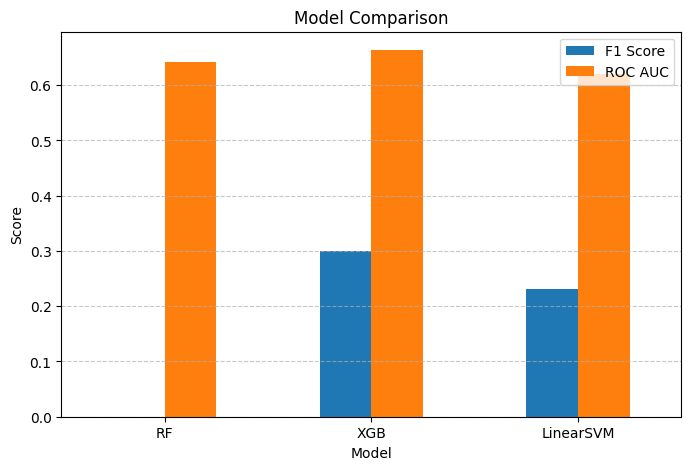

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import f1_score, brier_score_loss, roc_auc_score
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.pipeline import Pipeline

# Encode target
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

results = []

for name, model in models.items():
    print(f"\n🚀 Training {name}...")
    start = time.time()

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    pipeline.fit(X_train, y_train_enc)
    train_time = round(time.time() - start, 2)

    # Probabilities / Predictions
    if hasattr(pipeline.named_steps["model"], "predict_proba"):
        y_proba = pipeline.predict_proba(X_test)
        if y_proba.shape[1] == 2:
            y_proba_final = y_proba[:, 1]
        else:
            y_proba_final = y_proba
    else:
        y_scores = pipeline.decision_function(X_test)
        y_proba_final = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())

    y_pred = pipeline.predict(X_test)

    # Metrics
    if len(np.unique(y_test_enc)) > 2:
        y_test_bin = label_binarize(y_test_enc, classes=np.unique(y_test_enc))
        roc = roc_auc_score(y_test_bin, y_proba_final, average="weighted", multi_class="ovr")
        f1 = f1_score(y_test_enc, y_pred, average="weighted")
        brier = np.nan
    else:
        roc = roc_auc_score(y_test_enc, y_proba_final)
        f1 = f1_score(y_test_enc, y_pred)
        brier = brier_score_loss(y_test_enc, y_proba_final)

    results.append({
        "Model": name,
        "F1 Score": round(f1, 4),
        "Brier Score": round(brier, 4) if not np.isnan(brier) else np.nan,
        "ROC AUC": round(roc, 4),
        "Train Time (s)": train_time
    })

    print(f"✅ {name} -> F1: {f1:.4f}, ROC AUC: {roc:.4f}, Time: {train_time:.2f}s")

# Results table
results_df = pd.DataFrame(results)
display(results_df)

# Visualization
results_df.plot(x="Model", y=["F1 Score", "ROC AUC"], kind="bar", figsize=(8,5))
plt.title("Model Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.show()

In [ ]:
if 'readmitted' in data.columns:
    data['readmitted_target'] = data['readmitted'].apply(lambda x: 1 if x == '>30' else 0)
    data.drop(columns=['readmitted'], inplace=True)


In [ ]:
print(data.columns)


Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted_target'],
      dtype='object')


Files in ZIP: ['diabetic_data.csv', 'IDS_mapping.csv']
Dataset shape: (101766, 50)
Readmission column found: readmitted
Unique values: ['NO' '>30' '<30']

📊 Evaluation for Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.00      0.00      0.00      2271

    accuracy                           0.89     20354
   macro avg       0.44      0.50      0.47     20354
weighted avg       0.79      0.89      0.84     20354



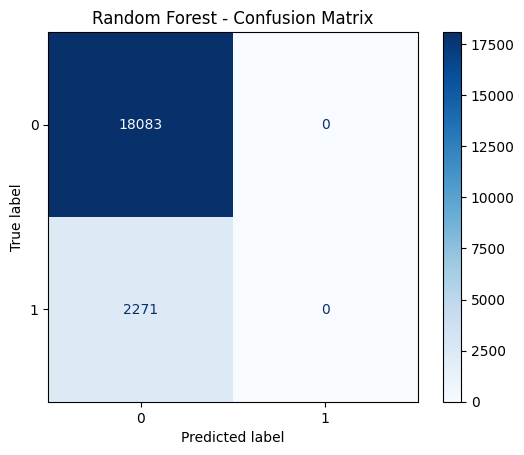


📊 Evaluation for Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.48      0.02      0.04      2271

    accuracy                           0.89     20354
   macro avg       0.69      0.51      0.49     20354
weighted avg       0.84      0.89      0.84     20354



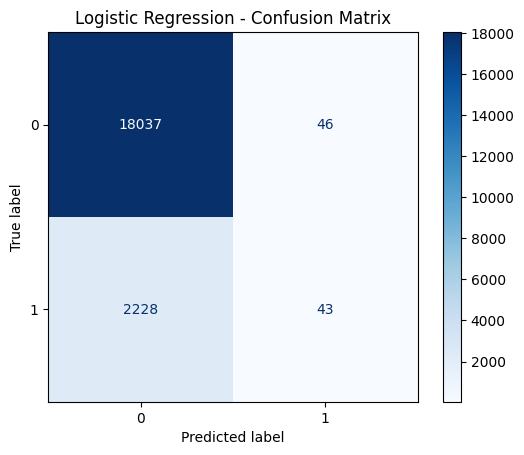


📊 Evaluation for XGBoost
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.59      0.02      0.04      2271

    accuracy                           0.89     20354
   macro avg       0.74      0.51      0.49     20354
weighted avg       0.86      0.89      0.84     20354



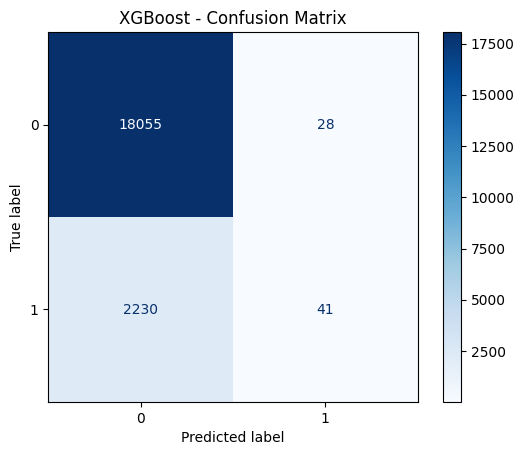

In [18]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ------------------- Load Dataset -------------------
zip_path = "C:/Users/user/Downloads/diabetes+130-us+hospitals+for+years+1999-2008.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    print("Files in ZIP:", zip_ref.namelist())
    data = pd.read_csv(zip_ref.open('diabetic_data.csv'))

print("Dataset shape:", data.shape)

# ------------------- Identify Readmission Column -------------------
readmit_col = None
for col in data.columns:
    if 'readmit' in col.lower():
        readmit_col = col
        break

if readmit_col is None:
    raise ValueError("No readmission column found in dataset!")

print(f"Readmission column found: {readmit_col}")
print("Unique values:", data[readmit_col].unique()[:10])

# ------------------- Create Binary Target -------------------
# 1 = readmitted within 30 days, 0 = not readmitted or after 30 days
data['target'] = data[readmit_col].apply(lambda x: 1 if x == '<30' else 0)
data.drop(columns=[readmit_col], inplace=True)

# ------------------- Split Features and Target -------------------
X = data.drop(columns=['target'], errors='ignore')
y = data['target']

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# ------------------- Preprocessor -------------------
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# ------------------- Train-Test Split -------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Encode target
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# ------------------- Models -------------------
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),  # Replaced SVM
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# ------------------- Evaluation -------------------
for name, model in models.items():
    print(f"\n📊 Evaluation for {name}")

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train_enc)
    y_pred = pipeline.predict(X_test)

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test_enc, y_pred, target_names=le.classes_.astype(str)))

    # Confusion matrix
    cm = confusion_matrix(y_test_enc, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()


📊 Random Forest Evaluation
Accuracy: 0.8884
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


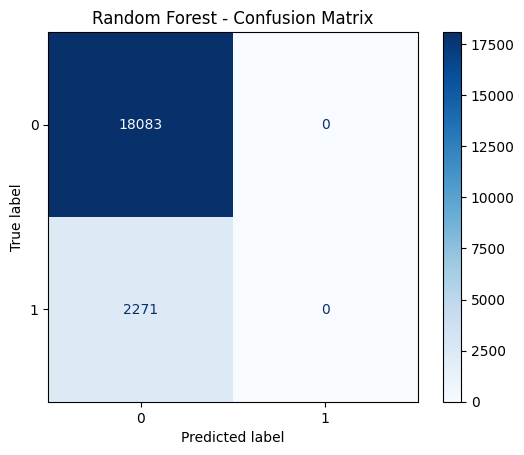


📊 Logistic Regression Evaluation
Accuracy: 0.8883
Precision: 0.4831
Recall: 0.0189
F1 Score: 0.0364


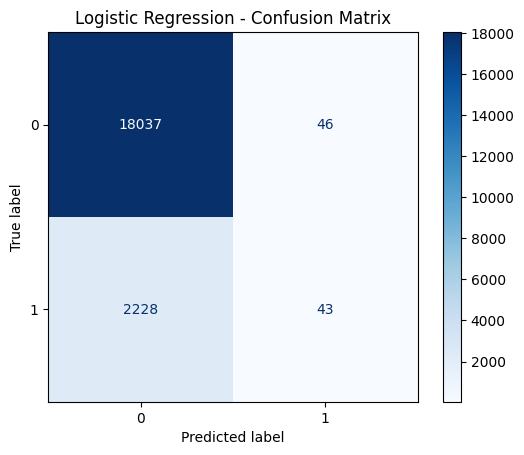


📊 XGBoost Evaluation
Accuracy: 0.8889
Precision: 0.6316
Recall: 0.0106
F1 Score: 0.0208


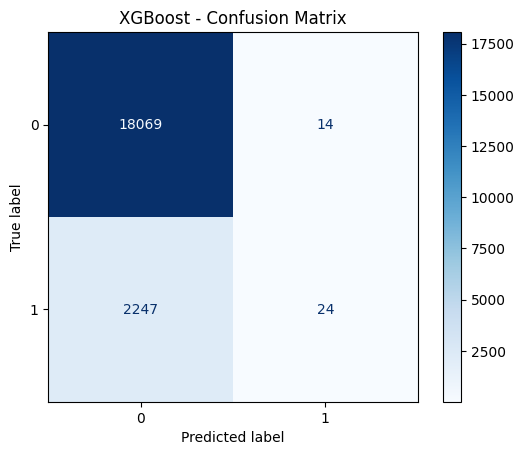

In [20]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ------------------- Load Dataset -------------------
zip_path = "C:/Users/user/Downloads/diabetes+130-us+hospitals+for+years+1999-2008.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    data = pd.read_csv(zip_ref.open('diabetic_data.csv'))

# ------------------- Binary Target -------------------
readmit_col = [c for c in data.columns if 'readmit' in c.lower()]
if not readmit_col:
    raise ValueError("No readmission column found!")
readmit_col = readmit_col[0]

data['target'] = data[readmit_col].apply(lambda x: 1 if x == '<30' else 0)
data.drop(columns=[readmit_col], inplace=True)

# ------------------- Features -------------------
X = data.drop(columns=['target'])
y = data['target']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numeric_features),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('encoder', OneHotEncoder(handle_unknown='ignore'))]), categorical_features)
    ]
)

# ------------------- Train-Test Split -------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ------------------- Encode Target -------------------
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# ------------------- Models -------------------
models = {
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=6, random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=50, max_depth=5, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# ------------------- Evaluation -------------------
for name, model in models.items():
    print(f"\n📊 {name} Evaluation")

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train_enc)
    y_pred = pipeline.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test_enc, y_pred)
    prec = precision_score(y_test_enc, y_pred)
    rec = recall_score(y_test_enc, y_pred)
    f1 = f1_score(y_test_enc, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test_enc, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()
